In [1]:
from main import *
from sklearn import clone

DROP_COLS = ["car_ownership", "house_ownership", "married"]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.935, total=  13.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.1s remaining:    0.0s


[CV] .................................... , score=0.937, total=  10.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   24.0s remaining:    0.0s


[CV] .................................... , score=0.937, total=  12.2s
[CV]  ................................................................
[CV] .................................... , score=0.936, total=  11.3s
[CV]  ................................................................
[CV] .................................... , score=0.936, total=  10.7s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   58.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.937, total=  13.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.6s remaining:    0.0s


[CV] .................................... , score=0.938, total=  14.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   27.6s remaining:    0.0s


[CV] .................................... , score=0.939, total=  13.4s
[CV]  ................................................................
[CV] .................................... , score=0.938, total=  13.4s
[CV]  ................................................................
[CV] .................................... , score=0.939, total=  13.4s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.937, total=   9.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.7s remaining:    0.0s


[CV] .................................... , score=0.936, total=  10.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.2s remaining:    0.0s


[CV] .................................... , score=0.936, total=  10.0s
[CV]  ................................................................
[CV] .................................... , score=0.936, total=   9.6s
[CV]  ................................................................
[CV] .................................... , score=0.936, total=   9.6s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   49.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.938, total=  12.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.0s remaining:    0.0s


[CV] .................................... , score=0.939, total=  13.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   25.1s remaining:    0.0s


[CV] .................................... , score=0.938, total=  11.5s
[CV]  ................................................................
[CV] .................................... , score=0.938, total=  11.7s
[CV]  ................................................................
[CV] .................................... , score=0.938, total=  11.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   59.8s finished


<AxesSubplot:>

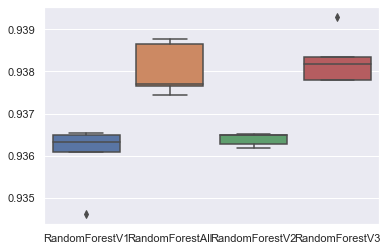

In [2]:
clf = RandomForestClassifier(n_jobs=-1)
models = {
    "RandomForestV1": [clone(clf), ["car_ownership", "house_ownership", "married", "profession", "city", "state"]],
    "RandomForestAll": [clone(clf), []],
    "RandomForestV2": [clone(clf), ["profession", "city", "state"]],
    "RandomForestV3": [clone(clf), ["car_ownership", "house_ownership", "married"]]
}

res = pd.DataFrame.from_dict(
        {model_name: eval_model(model, data_preprocess(drop_cols, [])[0]) for model_name, (model, drop_cols) in models.items()}    
    )
sns.boxplot(data=res)

## Note: can safely remove `["car_ownership", "house_ownership", "married"]`

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.938, total=  12.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.6s remaining:    0.0s


[CV] .................................... , score=0.940, total=   9.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.0s remaining:    0.0s


[CV] .................................... , score=0.938, total=   8.6s
[CV]  ................................................................
[CV] .................................... , score=0.938, total=   8.6s
[CV]  ................................................................
[CV] .................................... , score=0.939, total=   9.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   48.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.937, total=  16.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.8s remaining:    0.0s


[CV] .................................... , score=0.937, total=  15.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   32.7s remaining:    0.0s


[CV] .................................... , score=0.939, total=  16.6s
[CV]  ................................................................
[CV] .................................... , score=0.938, total=  16.9s
[CV]  ................................................................
[CV] .................................... , score=0.938, total=  16.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.937, total=  25.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.5s remaining:    0.0s


[CV] .................................... , score=0.939, total=  23.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   48.6s remaining:    0.0s


[CV] .................................... , score=0.937, total=  25.1s
[CV]  ................................................................
[CV] .................................... , score=0.938, total=  26.2s
[CV]  ................................................................
[CV] .................................... , score=0.938, total=  24.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.937, total=  33.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.4s remaining:    0.0s


[CV] .................................... , score=0.939, total=  32.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] .................................... , score=0.938, total=  32.1s
[CV]  ................................................................
[CV] .................................... , score=0.937, total=  33.3s
[CV]  ................................................................
[CV] .................................... , score=0.937, total=  35.7s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.8min finished


<AxesSubplot:>

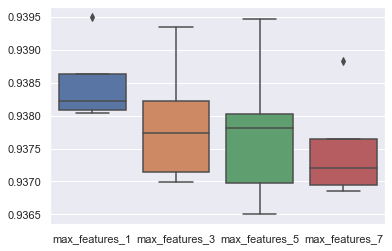

In [19]:
drop_cols = ["car_ownership", "house_ownership", "married"]
df_train = data_preprocess(drop_cols, [transformfn1])[0]

param = "max_features"
par_vals = [i+1 for i in range(0, df_train.shape[1]-1, 2)]

res = pd.DataFrame.from_dict(
        {f"{param}_{val}": eval_model(RandomForestClassifier(n_jobs=-1, **{param: val}), df_train)
                                      for val in par_vals}
    )
sns.boxplot(data=res)

## Note: a smaller `max_features` value seems better
---

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[19:14:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] .................................... , score=0.873, total=   3.1s
[CV]  ................................................................
[19:14:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV] .................................... , score=0.877, total=   2.1s
[CV]  ................................................................
[19:14:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.2s remaining:    0.0s


[CV] .................................... , score=0.874, total=   2.3s
[CV]  ................................................................
[19:14:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] .................................... , score=0.872, total=   2.3s
[CV]  ................................................................
[19:14:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] .................................... , score=0.876, total=   2.2s
[CV]  ...................

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] .................................... , score=0.880, total=   2.2s
[CV]  ................................................................
[19:14:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] .................................... , score=0.878, total=   2.2s
[CV]  ................................................................
[19:14:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s


[CV] .................................... , score=0.875, total=   2.2s
[CV]  ................................................................
[19:14:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] .................................... , score=0.880, total=   2.3s
[CV]  ................................................................
[19:14:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] .................................... , score=0.872, total=   2.2s
[CV]  ...................

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] .................................... , score=0.877, total=   2.2s
[CV]  ................................................................
[19:14:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] .................................... , score=0.883, total=   2.3s
[CV]  ................................................................
[19:14:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.4s remaining:    0.0s


[CV] .................................... , score=0.878, total=   2.2s
[CV]  ................................................................
[19:14:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] .................................... , score=0.878, total=   2.2s
[CV]  ................................................................
[19:14:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] .................................... , score=0.875, total=   2.3s
[CV]  ...................

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] .................................... , score=0.879, total=   2.2s
[CV]  ................................................................
[19:14:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] .................................... , score=0.881, total=   2.3s
[CV]  ................................................................
[19:14:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s


[CV] .................................... , score=0.878, total=   2.3s
[CV]  ................................................................
[19:14:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] .................................... , score=0.880, total=   2.3s
[CV]  ................................................................
[19:14:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] .................................... , score=0.884, total=   2.4s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.5s finished


<AxesSubplot:>

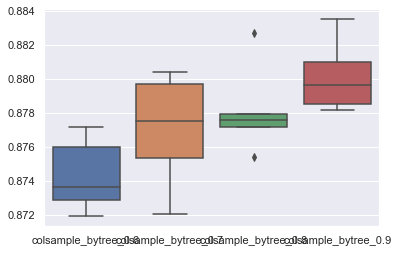

In [12]:
drop_cols = ["car_ownership", "house_ownership", "married"]
df_train = data_preprocess(drop_cols, [income_by_state])[0]

param = "colsample_bytree"
par_vals = [0.6, 0.7, 0.8, 0.9]

res = pd.DataFrame.from_dict(
        {f"{param}_{val}": eval_model(XGBClassifier(
            n_estimators=200, 
            learning_rate=0.1,
            reg_alpha=1e-3,
            tree_method="gpu_hist",
            scale_pos_weight=12,
            **{param: val}), df_train)
                                      for val in par_vals}
    )
sns.boxplot(data=res)

In [ ]:
from sklearn.ensemble import StackingClassifier
models = [
    ("rfV1", RandomForestClassifier(n_estimators=200, n_jobs=2)),
    ("rfV2", RandomForestClassifier(n_estimators=200, class_weight="balanced", max_features=1, n_jobs=2)),
    ("xgb", XGBClassifier(n_estimators=5000, 
            learning_rate=0.01,
            tree_method="gpu_hist",
            scale_pos_weight=7.13,
            min_child_weight=2,
            colsample_bytree=0.6)),
]

final_estimator = RandomForestClassifier(n_estimators=1000, class_weight="balanced", n_jobs=2)
model = StackingClassifier(estimators=models, final_estimator=final_estimator, cv=CV, verbose=1000)

df_train = data_preprocess(DROP_COLS, [income_by_state])[0]
eval_model(model, df_train)

In [18]:
from sklearn.model_selection import train_test_split
def get_model_outputs(models):
    df_train = data_preprocess(
            drop_cols=["car_ownership", "house_ownership", "married"],
            transform_fns=[income_by_state]
        )[0]

    scores = {}
    for name, model in models.items():
        print(f"Cross-validating: {name}")
        scores[name] = eval_model(model, df_train)
    scores = pd.DataFrame.from_dict(scores)
    
    X, y = df_train.drop("risk_flag", axis=1).values, df_train["risk_flag"].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    
    for name in models.keys():
        models[name].fit(X_train, y_train)
    
    preds = {name: model.predict(X_test) for name, model in models.items()}
    return preds, scores

In [34]:
from sklearn.tree import DecisionTreeClassifier
model_list = {
#     "rfv1": RandomForestClassifier(n_jobs=2),
#     "rfv2": RandomForestClassifier(class_weight="balanced", max_features=1, n_jobs=2),
#     "rfv3": RandomForestClassifier(criterion="entropy", n_jobs=2, max_depth=10),
#     "rfv4": RandomForestClassifier(criterion="entropy", n_jobs=2, max_features=2, max_depth=15),
#     "xgb": XGBClassifier(n_estimators=1000, 
#             learning_rate=0.1,
#             tree_method="gpu_hist",
#             scale_pos_weight=7.13,
#             min_child_weight=2,
#             colsample_bytree=0.9),
#     "extratreesv2": ExtraTreesClassifier(n_estimators=200, n_jobs=2, class_weight="balanced", max_depth=10),
#     "extratreesv3": ExtraTreesClassifier(n_estimators=200, n_jobs=2, class_weight="balanced", criterion="entropy", max_features=1, max_depth=10),
    "adb": AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=200, learning_rate=0.1)
}
preds, scores = get_model_outputs(model_list)

Cross-validating: adb


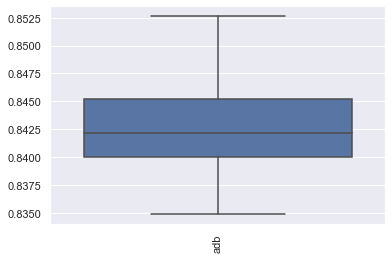

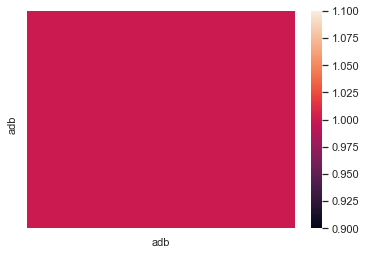

In [35]:
sns.boxplot(data=scores)
plt.tick_params(axis='x', rotation=90)
plt.show()
sns.heatmap(pd.DataFrame.from_dict(preds).corr())
plt.show()

In [38]:
df_train = data_preprocess(
            drop_cols=["car_ownership", "house_ownership", "married"],
            transform_fns=[income_by_state]
        )[0]
base_models = [
        ("rfv1", RandomForestClassifier(n_jobs=2)),
        ("rfv2", RandomForestClassifier(class_weight="balanced", max_features=1, n_jobs=2)),
        ("rfv3", RandomForestClassifier(criterion="entropy", n_jobs=2, max_depth=10)),
        ("rfv4", RandomForestClassifier(criterion="entropy", n_jobs=2, max_features=2, max_depth=15)),
        ("xgb", XGBClassifier(n_estimators=1000, learning_rate=0.1, tree_method="gpu_hist", scale_pos_weight=7.13, min_child_weight=2, colsample_bytree=0.9)),
        ("extratreesv2", ExtraTreesClassifier(n_estimators=200, n_jobs=2, class_weight="balanced", max_depth=10)),
        ("extratreesv3", ExtraTreesClassifier(n_estimators=200, n_jobs=2, class_weight="balanced", criterion="entropy", max_features=1, max_depth=10)),
        ("adb", AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=200, learning_rate=0.1))
    ]
final_clf = RandomForestClassifier(n_jobs=2, class_weight="balanced")
model = StackingClassifier(estimators=base_models, final_estimator=final_clf, cv=CV, passthrough=True)
# scores = eval_model(model, df_train)

In [ ]:
sub = make_submission(model, df_train, df_test)